In [2]:
from PIL import Image
import random
import math
import time
from IPython.display import display
from IPython.display import clear_output
from PIL import Image, ImageDraw , ImageFont

im_size = (240,240)
pastelColorPallet = [(27,133,184),(90,82,85),(85,158,131),(174,90,65),(195,203,113),(249,107,75),(249,167,143),(195,155,211),(161,126,111)]


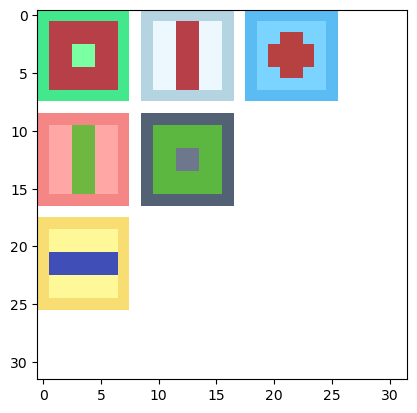

In [373]:
import zlib
import struct

f = open('3d_models/cube_texture.png', 'rb')

PngSignature = b'\x89PNG\r\n\x1a\n'
if f.read(len(PngSignature)) != PngSignature:
    raise Exception('Invalid PNG Signature')

def read_chunk(f):
    # Returns (chunk_type, chunk_data)
    chunk_length, chunk_type = struct.unpack('>I4s', f.read(8))
    chunk_data = f.read(chunk_length)
    chunk_expected_crc, = struct.unpack('>I', f.read(4))
    chunk_actual_crc = zlib.crc32(chunk_data, zlib.crc32(struct.pack('>4s', chunk_type)))
    if chunk_expected_crc != chunk_actual_crc:
        raise Exception('chunk checksum failed')
    return chunk_type, chunk_data

chunks = []
while True:
    chunk_type, chunk_data = read_chunk(f)
    chunks.append((chunk_type, chunk_data))
    if chunk_type == b'IEND':
        break

_, IHDR_data = chunks[0] # IHDR is always first chunk
width, height, bitd, colort, compm, filterm, interlacem = struct.unpack('>IIBBBBB', IHDR_data)
if compm != 0:
    raise Exception('invalid compression method')
if filterm != 0:
    raise Exception('invalid filter method')
if colort != 6:
    raise Exception('we only support truecolor with alpha')
if bitd != 8:
    raise Exception('we only support a bit depth of 8')
if interlacem != 0:
    raise Exception('we only support no interlacing')

IDAT_data = b''.join(chunk_data for chunk_type, chunk_data in chunks if chunk_type == b'IDAT')
IDAT_data = zlib.decompress(IDAT_data)

def PaethPredictor(a, b, c):
    p = a + b - c
    pa = abs(p - a)
    pb = abs(p - b)
    pc = abs(p - c)
    if pa <= pb and pa <= pc:
        Pr = a
    elif pb <= pc:
        Pr = b
    else:
        Pr = c
    return Pr

Recon = []
bytesPerPixel = 4
stride = width * bytesPerPixel

def Recon_a(r, c):
    return Recon[r * stride + c - bytesPerPixel] if c >= bytesPerPixel else 0

def Recon_b(r, c):
    return Recon[(r-1) * stride + c] if r > 0 else 0

def Recon_c(r, c):
    return Recon[(r-1) * stride + c - bytesPerPixel] if r > 0 and c >= bytesPerPixel else 0

i = 0
pixels = []
pixelsRow = []
pixelIndex = 0
pixelValues = []
for r in range(height): # for each scanline
    filter_type = IDAT_data[i] # first byte of scanline is filter type
    i += 1
    for c in range(stride): # for each byte in scanline
        Filt_x = IDAT_data[i]
        i += 1
        if filter_type == 0: # None
            Recon_x = Filt_x
        elif filter_type == 1: # Sub
            Recon_x = Filt_x + Recon_a(r, c)
        elif filter_type == 2: # Up
            Recon_x = Filt_x + Recon_b(r, c)
        elif filter_type == 3: # Average
            Recon_x = Filt_x + (Recon_a(r, c) + Recon_b(r, c)) // 2
        elif filter_type == 4: # Paeth
            Recon_x = Filt_x + PaethPredictor(Recon_a(r, c), Recon_b(r, c), Recon_c(r, c))
        else:
            raise Exception('unknown filter type: ' + str(filter_type))
        pixelValues.append(Recon_x & 0xff)
        pixelIndex += 1
        Recon.append(Recon_x & 0xff) # truncation to byte
        if pixelIndex > 3:
            pixelIndex = 0
            pixelsRow.append(pixelValues)
            pixelValues = []
        if len(pixelsRow) >= width:
            pixels.append(pixelsRow)
            pixelsRow = []

import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.array(pixels))
plt.show()

In [922]:

def rotPnt(pnt,ang):
    rotY = getYrot(ang[1]) 
    rotX = getXrot(ang[0])
    rot_a = transformVec(rotY[0],rotY[1],rotY[2],rotX[0])
    rot_b = transformVec(rotY[0],rotY[1],rotY[2],rotX[1])
    rot_c = transformVec(rotY[0],rotY[1],rotY[2],rotX[2])
    pnt_out = transformVec(rot_a,rot_b,rot_c,pnt)
    return pnt_out
    
def getYrot(ang_d):
    ang = math.radians(ang_d)
    xhat = (math.cos(ang),0.0,math.sin(ang))
    yhat = (0.0,1.0,0.0)
    zhat = (-math.sin(ang),0.0,math.cos(ang))
    return (xhat,yhat,zhat)
    
def getXrot(ang_d):
    ang = math.radians(ang_d)
    xhat = (1.0,0.0,0.0)
    yhat = (0.0,math.cos(ang),-math.sin(ang))
    zhat = (0.0,math.sin(ang),math.cos(ang))
    return (xhat,yhat,zhat)

def rotcamPnt(pnt,ang):
    rotY = getYrot(-ang[1]) 
    rotX = getXrot(-ang[0])
    rot_a = transformVec(rotX[0],rotX[1],rotX[2],rotY[0])
    rot_b = transformVec(rotX[0],rotX[1],rotX[2],rotY[1])
    rot_c = transformVec(rotX[0],rotX[1],rotX[2],rotY[2])
    pnt_out = transformVec(rot_a,rot_b,rot_c,pnt)
    return pnt_out

def transformVec(xhat,yhat,zhat,pnt):
    out_x = xhat[0]*pnt[0]+yhat[0]*pnt[1]+zhat[0]*pnt[2]
    out_y = xhat[1]*pnt[0]+yhat[1]*pnt[1]+zhat[1]*pnt[2]
    out_z = xhat[2]*pnt[0]+yhat[2]*pnt[1]+zhat[2]*pnt[2]
    #print((out_x,out_y,out_z))
    return (out_x,out_y,out_z)
    
def dot_(a, b):
    s = 0
    for i in range(0, len(b)):
        s += a[i] * b[i]
    return s

def cross_3d(a,b):
    return (a[1]*b[2]-a[2]*b[1],-(a[0]*b[2]-a[2]*b[0]),a[0]*b[1]-a[1]*b[0])
    
def getperpendicular_clock(a):
    return (a[1],-a[0])

def posPnt(pnt,pos):
    return((pnt[0]+pos[0],pnt[1]+pos[1],pnt[2]+pos[2]))

def getArea(a,b,p):
    ap = (p[0] - a[0],p[1] - a[1])
    ab_perp = getperpendicular_clock((b[0]-a[0],b[1]-a[1]))
    return abs(dot_(ap,ab_perp))

def verticeToScreen(vertice,ang,pos,screen_size,cam_ang = (0,0)):
    pnt = rotPnt(vertice,ang)
    pnt = posPnt(pnt,pos)
    pnt = rotcamPnt(pnt,cam_ang)
    FOV = math.radians(60)
    screenHeightWorld = math.tan(FOV/2)*2
    if pnt[2] <= 0:
        return None
    pixelsPerUnitWorld = screen_size[1]/screenHeightWorld/pnt[2]
    pixelOffset = (pnt[0]*pixelsPerUnitWorld,pnt[1]*pixelsPerUnitWorld)

    
    return ((screen_size[0]/2)+pixelOffset[0],(screen_size[1]/2)+pixelOffset[1])

def getlineX(strt_pnt,slope,y):
    x0,y0 = strt_pnt
    if slope == 0:
        return x0 
    elif slope == math.inf:
        return x0
    else:
        return int(((y-y0)/slope)+x0)

def transformColor(Color,ilumi):
    newColor = []
    for i in range(3):
        col = int(Color[i]*(ilumi-0.5))
        if col > 255:
            col = 255
        elif col < 0:
            col = 0
        newColor.append(col)
    #print(Color,' -> ',newColor)
    return tuple(newColor)
    
def PointsDistance3d(a,b):
    return math.sqrt( (a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2 )
    
class line_2d():
    def __init__(self,a,b):
        self.a = a
        self.b = b

    def getSlope(self):
        subx = (self.a[0] - self.b[0])
        if subx == 0:
            return math.inf
        return (self.a[1] - self.b[1])/subx
    
class triangle_2d():
    def __init__(self,a,b,c,UV=None,color = (255, 255, 255),lumination=0):
        stdpnts = sorted([a,b,c], key=lambda tup: tup[1])
        self.a = stdpnts[0]
        self.b = stdpnts[1]
        self.c = stdpnts[2]
        self.ab = line_2d(self.a,self.b)
        self.bc = line_2d(self.b,self.c)
        self.ca = line_2d(self.c,self.a)
        self.ab_slope = self.ab.getSlope()
        self.bc_slope = self.bc.getSlope()
        self.ca_slope = self.ca.getSlope()
        self.color = color
        self.texture_size = (32,32)
        self.stdByx = sorted([a,b,c], key=lambda tup: tup[0])
        self.UVstdbyx = None
        if UV != None:
            UV = sorted(UV, key=lambda tup: tup[1])
            self.UVstdbyx = sorted(UV, key=lambda tup: tup[0])
        self.UV = UV
        
    def triangleArea(self):
        ac = (self.c[0]-self.a[0],self.c[1]-self.a[1])
        ab_perp = getperpendicular_clock((self.b[0]-self.a[0],self.b[1]-self.a[1]))
        return dot_(ac,ab_perp)

    def getPointColor(self,A_ab,A_ac,A_bc):
        xdif = self.UVstdbyx[2][0] - self.UVstdbyx[0][0]
        ydif = self.UV[2][1]-self.UV[0][1]
        a_norm = ((self.UV[0][0]-self.UVstdbyx[0][0])/xdif,0)
        b_norm = ((self.UV[1][0]-self.UVstdbyx[0][0])/xdif,(self.UV[1][1]-self.UV[0][1])/ydif)
        c_norm = ((self.UV[2][0]-self.UVstdbyx[0][0])/xdif,1)
        invASum = 1/(A_ab+A_ac+A_bc)
        x_norm = (a_norm[0]*A_bc + b_norm[0]*A_ac + c_norm[0]*A_ab)*invASum
        y_norm = (a_norm[1]*A_bc + b_norm[1]*A_ac + c_norm[1]*A_ab)*invASum
        u = (x_norm*xdif)+self.UVstdbyx[0][0]
        v = (x_norm*ydif)+self.UV[0][1]
        
        pix_x = int((u) * self.texture_size[0])
        pix_y = int((1-v) * self.texture_size[1])
        
        if pix_x > self.texture_size[0]-1:
            print(pix_x,pix_y)
        if pix_y > self.texture_size[1]-1:
            print(pix_x,pix_y)
        
        return tuple(pixels[pix_x][pix_y][:3])
    
    def half_render(self,ystart,ystop,pnt0,pnt1,slope0,slope1,im,wireframe=False):
        for y in range(int(ystart),int(ystop)):
            x0 = getlineX(pnt0,slope0,y)
            x1 = getlineX(pnt1,slope1,y)             
            x0 = max(min(x0, im_size[0]-1), 0)
            x1 = max(min(x1, im_size[0]-1), 0)
            y = max(min(y, im_size[1]-1), 0)
            x_pnts = sorted([x0,x1])
            if wireframe:
                im.putpixel((x_pnts[0],y), self.color)
                im.putpixel((x_pnts[1],y), self.color)
            else:
                for x in range(int(x_pnts[0]),int(x_pnts[1])):
                    #print(x,y)
                    if self.UV != None:
                        a_norm = ((self.a[0]-self.stdByx[0][0])/(self.stdByx[2][0] - self.stdByx[0][0]),0)
                        b_norm = ((self.b[0]-self.stdByx[0][0])/(self.stdByx[2][0] - self.stdByx[0][0]),(self.b[1]-self.a[1])/(self.c[1]-self.a[1]))
                        c_norm = ((self.c[0]-self.stdByx[0][0])/(self.stdByx[2][0] - self.stdByx[0][0]),1)
                        pnt_norm  =( (x-self.stdByx[0][0])/(self.stdByx[2][0] - self.stdByx[0][0]),(y-self.a[1])/(self.c[1]-self.a[1]) )
                        A_ab = getArea(a_norm,b_norm,pnt_norm)
                        A_ac = getArea(a_norm,c_norm,pnt_norm)
                        A_bc = getArea(b_norm,c_norm,pnt_norm)
                        #invASum = 1/(A_ab+A_ac+A_bc)
                        #x_norm = (a_norm[0]*A_bc + b_norm[0]*A_ac + c_norm[0]*A_ab)*invASum
                        #y_norm = (a_norm[1]*A_bc + b_norm[1]*A_ac + c_norm[1]*A_ab)*invASum
                        im.putpixel((x,y), self.getPointColor(A_ab,A_ac,A_bc))
                    else: 
                        im.putpixel((x,y), self.color)
                    
    def render(self,im):
        #print(self.triangleArea()," ",self.a,self.b,self.c)
        self.half_render(self.a[1],self.b[1],self.a,self.a,self.ab_slope,self.ca_slope,im)
        self.half_render(self.b[1],self.c[1],self.b,self.a,self.bc_slope,self.ca_slope,im)

class triangle_3d():
    def __init__(self,a,b,c,ang,pos,UV = None,color = (255, 255, 255) ):
        self.a = a
        self.b = b
        self.c = c
        self.color = color
        self.ang = ang
        self.pos = pos
        self.UV = UV

    def facingVectorCheck(self,camNormal):
        dot = dot_(self.getNormal(),camNormal) 
        #print(self.getNormal(),' ',(dot> 0))
        return (dot> 0)
        
    def getNormal(self):
        a,b,c = self.getUpdatedVertices()
        ac = (c[0]-a[0],c[1]-a[1],c[2]-a[2])
        ab = (b[0]-a[0],b[1]-a[1],b[2]-a[2])
        cross = cross_3d(ac,ab)
        crosslen = math.sqrt(cross[0]**2+cross[1]**2+cross[2]**2)
        normal = (cross[0]/crosslen,cross[1]/crosslen,cross[2]/crosslen)
        return normal
        
    def getClosestdistance(self,pnt):
        distances = []
        for v in [self.a,self.b,self.c]:
            distances.append(PointsDistance3d(v,pnt))
        return min(distances)
        
    def getCentroid(self):
        cx = (self.a[0]+self.b[0]+self.c[0])/3
        cy = (self.a[1]+self.b[1]+self.c[1])/3
        cz = (self.a[2]+self.b[2]+self.c[2])/3
        return((cx,cy,cz))
    
    def getDistanceToCentroid(self,pnt):
        c = self.getCentroid()
        #print(c)
        c = rotPnt(c,self.ang)
        c = posPnt(c,self.pos)
        return PointsDistance3d(c,pnt)
        
    def trig_3dToTrig_2d(self,cam_ang):
        a_ = verticeToScreen(self.a,self.ang,self.pos,im_size,cam_ang = cam_ang)
        b_ = verticeToScreen(self.b,self.ang,self.pos,im_size,cam_ang = cam_ang)
        c_ = verticeToScreen(self.c,self.ang,self.pos,im_size,cam_ang = cam_ang)

        if a_ == None or b_ == None or c_ == None:
            return None
        lightdirection = (0,0.8,0.2)
        global_ilumi = 0.7
        ilumi = dot_(lightdirection,self.getNormal())
        ilumi += global_ilumi
        if ilumi < 1:
            ilumi = 1 +ilumi
        if ilumi > 1.5:
            ilumi = 1.5
        newColor = transformColor(self.color,ilumi)
        return triangle_2d(a_,b_,c_,UV=self.UV,color=newColor)
    
    def getUpdatedVertices(self):
        a = rotPnt(self.a,self.ang)
        a = posPnt(a,self.pos)
        b = rotPnt(self.b,self.ang)
        b = posPnt(b,self.pos)
        c = rotPnt(self.c,self.ang)
        c = posPnt(c,self.pos)
        return (a,b,c)
    
    def update(self,ang,pos):
        self.pos = pos
        self.ang = ang
        
    def render(self,im,cam_ang=(0,0)):
        #self.trig_3dToTrig_2d().render_old(im)
        tri_2d = self.trig_3dToTrig_2d(cam_ang = cam_ang)
        if tri_2d != None:
            tri_2d.render(im)
        
class model():
    def __init__(self,vertices,UV,tri_indexes,pos=(0,0,0),ang=(0,0),updateVertices = False):
        self.vertices = vertices
        self.UV = UV
        self.tri_indexes = tri_indexes
        self.ang = ang
        self.pos = pos
        self.colorPallet = pastelColorPallet
        self.triangles = []
        self.updateTriangles(updateVertices=updateVertices)
        
    def updateTriangles(self,updateVertices=False):
        self.triangles = []
        if updateVertices:
            for i in range(len(self.vertices)):
                #print(": ",self.vertices[i])
                self.vertices[i] = rotPnt( self.vertices[i],self.ang)
                self.vertices[i] = posPnt( self.vertices[i],self.pos)
                #self.vertices[i] = (round(self.vertices[i][0], 2),round(self.vertices[i][1], 2),round(self.vertices[i][2], 2))
                #print("> ",self.vertices[i])
            self.ang = (0,0)
            self.pos = (0,0,0)
        for j,t_i in enumerate(self.tri_indexes):
            a = self.vertices[t_i[0][0]]
            b = self.vertices[t_i[0][1]]
            c = self.vertices[t_i[0][2]]
            uv_a = self.UV[t_i[1][0]]
            uv_b = self.UV[t_i[1][1]]
            uv_c = self.UV[t_i[1][2]]
            t = triangle_3d(a,b,c,self.ang,self.pos,UV = (uv_a,uv_b,uv_c),color=self.colorPallet[j%len(self.colorPallet)])
            #print(t.color)
            self.triangles.append(t)    

    def setColorPallet(self,colorPallet):
        self.colorPallet = colorPallet
        for t in self.triangles:
            t.color = self.colorPallet[j%len(self.colorPallet)]
        
    def render(self,im,cameraFacingCheck = False,cam_ang=(0,0)):
        tup_list = []
        for t in self.triangles:
            t.update(self.ang,self.pos)
            cam_dist = t.getDistanceToCentroid((0,0,0))
            tup_list.append((t,cam_dist))
        tup_list = sorted(tup_list, key=lambda tup: tup[1],reverse=True)
        #print(tup_list)
        for tup in tup_list:
            #print(tup[0].facingVectorCheck((0,0,1)))
            camNormal = rotcamPnt((0,0,1),cam_ang)
            if tup[0].facingVectorCheck(camNormal) and not cameraFacingCheck:
                tup[0].render(im,cam_ang=cam_ang)

class multipart_model(model):
    def __init__(self,models = []):
        model.__init__(self, [], [],[])
        self.models = models
        self.lastIndex = 0
        
    def addModel(self,m_obj):
        m_obj.updateTriangles(updateVertices=True)
        self.models.append(m_obj)
        self.triangles.extend(m_obj.triangles)
        
def loadObj(path,pos=(0,0,0),ang=(0,0)):
    with open(path) as file:
        lines = [line.rstrip() for line in file]
    tri_indexes = []
    triUV = []
    UV = []
    faces = []
    vertices = []
    
    for line in lines:
        
        if line[0:2] == 'v ':
            vertice_str = line[2:].split(' ')
            v = []
            for item in vertice_str:
                v.append(float(item))
            #print(v)
            vertices.append(tuple(v))
        if line[0:2] == "f ":
            face_str = line[2:].split(' ')
            f = []
            uv = []
            for tstr in face_str:
                f.append(int(tstr.split('/')[0]))
                uv.append(int(tstr.split('/')[1]))
            faces.append((tuple(f),tuple(uv)))
        if line[0:3] == "vt ":
            vetice_tex_str = line[3:].split(' ')
            UV.append((float(vetice_tex_str[0]),float(vetice_tex_str[1])))
    
    for face in faces:
        f = face[0]
        uv = face[1]
        #print(face)
        a = f[0]-1
        uv_a = uv[0]-1
        for i in range(len(face[0])-2):
            b = f[i+1]-1
            c = f[i+2]-1
            uv_b = uv[i+1]-1
            uv_c = uv[i+2]-1
            tri_indexes.append(((a,b,c),(uv_a,uv_b,uv_c)))
    return(model(vertices,UV,tri_indexes,pos=pos,ang=ang))




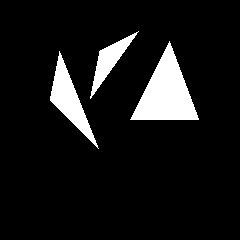

In [923]:
im = Image.new('RGB', im_size)
tri0 = triangle_2d((60,50),(50,100),(100,150))
tri1 = triangle_2d((100,50),(90,100),(140,30))
tri2 = triangle_2d((130,120),(200,120),(170,40))
tri0.render(im)
tri1.render(im)
tri2.render(im)
#tring.renderPoints(im)
im

In [924]:
tri2.stdByx

[(130, 120), (170, 40), (200, 120)]

In [925]:
getArea(tri0.a,tri0.b,tri0.c)

3000

In [926]:
getArea(tri1.a,tri1.b,tri1.c)

1800

In [927]:
getArea(tri2.a,tri2.b,tri2.c)

5600

In [928]:
cube = loadObj('3d_models/cube.obj',pos=(0,0,2),ang=(0,0))
print('uv:')
for uv in cube.UV:
    print(uv)
print('tri_indexes:')
for tri in cube.tri_indexes:
    print(tri)
print('vertices:')
for v in cube.vertices:
    print(v)

print('')

uv:
(0.25, 1.0)
(0.0, 1.0)
(0.0, 0.75)
(0.25, 0.75)
(0.25, 0.46875)
(0.25, 0.71875)
(0.0, 0.71875)
(0.0, 0.46875)
(0.28125, 0.75)
(0.53125, 0.75)
(0.53125, 1.0)
(0.28125, 1.0)
(0.53125, 0.46875)
(0.53125, 0.71875)
(0.28125, 0.71875)
(0.28125, 0.46875)
(0.25, 0.1875)
(0.25, 0.4375)
(0.0, 0.4375)
(0.0, 0.1875)
(0.8125, 1.0)
(0.5625, 1.0)
(0.5625, 0.75)
(0.8125, 0.75)
tri_indexes:
((1, 0, 2), (0, 1, 2))
((1, 2, 3), (0, 2, 3))
((6, 4, 5), (4, 5, 6))
((6, 5, 7), (4, 6, 7))
((4, 0, 1), (8, 9, 10))
((4, 1, 5), (8, 10, 11))
((3, 2, 6), (12, 13, 14))
((3, 6, 7), (12, 14, 15))
((2, 0, 4), (16, 17, 18))
((2, 4, 6), (16, 18, 19))
((5, 1, 3), (20, 21, 22))
((5, 3, 7), (20, 22, 23))
vertices:
(0.5, 0.5, 0.5)
(0.5, 0.5, -0.5)
(0.5, -0.5, 0.5)
(0.5, -0.5, -0.5)
(-0.5, 0.5, 0.5)
(-0.5, 0.5, -0.5)
(-0.5, -0.5, 0.5)
(-0.5, -0.5, -0.5)



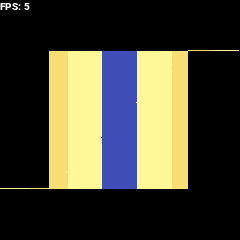

In [929]:
font = ImageFont.truetype('Roboto-Black.ttf')
i = 0
for j in range(360):
    i += 1
    im = Image.new('RGB', im_size)
    draw = ImageDraw.Draw(im)
    clear_output(wait=True)
    cube.ang = (i,j)
    start_time = time.time()
    cube.render(im)
    render_time = time.time()-start_time
    draw.text((0,0),"FPS: "+str(int(1/render_time)),font=font)
    display(im)